In [ ]:
# Some Required installation

!pip install kaggle
!pip install  keras_core keras_nlp
!pip install Keras-Preprocessing

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.utils import pad_sequences
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout,Input,Embedding,Flatten,TextVectorization,Conv1D,GlobalMaxPooling1D,MaxPooling1D,GlobalAveragePooling1D
from keras.initializers import Constant
from keras.layers import Dense,LSTM,Bidirectional,Attention,Concatenate,GRU,BatchNormalization
import nltk
from nltk.corpus import stopwords
import re
import seaborn as sns
nltk.download('stopwords')
import keras_core as keras
import keras_nlp



In [ ]:
# Enable multiple gpus
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

In [ ]:
data=pd.read_csv('/content/SC_4label.csv')
data

In [ ]:
labels=['DD','IO','RE','TD']
plt.figure(figsize = (8,5))
ax = sns.countplot(x = data['label_encoded'], palette = 'Set1', alpha = 0.8)
ax.set_xticklabels(labels)  # Set custom x-axis labels
#plt.title('Distribution of vulnerabilities')
plt.savefig('vul_distribution.pdf')
plt.show()

In [ ]:
X = data['code']
y = data['label_encoded']

In [ ]:
solidity_stopwords = [
    "pragma", "interface", "contract", "function", "event", "modifier", "library", "using",
    "string", "uint8", "uint256", "address", "mapping", "bool", "require", "return", "memory",
    "storage", "public", "internal", "view", "returns", "constant", "constructor",
    "_owner", "_balances", "_allowances", "_founder", "_marketing", "_who", "_burntAmount",
    "_from", "_to", "_value", "_timestamp", "_bool", "msg.sender", "totalSupply",
    "balanceOf", "transfer", "allowance", "approve", "transferFrom", "add", "sub", "mul", "div",
    "mod", "changeFounder", "setMinter", "setFurnace", "freezeAccount","solidity","bytes32"
]
def clean_solidity_code(solidity_code):
    # Remove comments (both single-line and multi-line)
    cleaned_code = re.sub(r'//.*?$', '', solidity_code, flags=re.MULTILINE)
    cleaned_code = re.sub(r'/\*.*?\*/', '', cleaned_code, flags=re.DOTALL)

    # Remove special characters and punctuation
    cleaned_code = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_code)

    # Remove extra whitespace and blank lines, and convert to lowercase
    cleaned_code = '\n'.join(line.strip().lower() for line in cleaned_code.splitlines() if line.strip())
    # Remove common English stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in cleaned_code.split() if word not in stop_words]
    tokens = [token for token in tokens if token not in solidity_stopwords]
    cleaned_code = ' '.join(tokens)

    return tokens

In [ ]:
X_cleaned = X.apply(clean_solidity_code)
X_cleaned_sentences = [' '.join(doc) for doc in X_cleaned]
X_cleaned_sentences=np.array(X_cleaned_sentences)
X_cleaned_sentences[1]

In [ ]:
#Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_cleaned_sentences, y,
                                                    test_size=0.1,shuffle=True,random_state=42,stratify=y)

In [ ]:
# one hot encoding label
y_train_encoded = to_categorical(y_train, 4)
y_test_encoded = to_categorical(y_test, 4)
y_train_encoded

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Define the vocabulary size and sequence length
vocab_size = 10000  # adjust as needed
sequence_length = 100  # adjust as needed

# Initialize TextVectorization layer
vectorizer = TextVectorization(max_tokens=vocab_size, output_sequence_length=sequence_length)

# Adapt the vectorizer on the training data
vectorizer.adapt(X_train)

# Vectorize the training and testing data
X_train_sequences = vectorizer(X_train)
X_test_sequences = vectorizer(X_test)


In [ ]:
# Padding the sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=128, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=128, padding='post', truncating='post')
print('Shape of training tensor: ', X_train_padded.shape)
print('Shape of testing tensor: ', X_test_padded.shape)

In [ ]:
#Smote oversampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
import math

def smote(x, y):
    k_neighbors = math.ceil(sum(y) * 0.01)

    smote = SMOTE(sampling_strategy=1,
                  k_neighbors=k_neighbors)
    x, y = smote.fit_resample(x, y)

    return x, y

def bordersmote(x, y):
    k_neighbors = math.ceil(sum(y) * 0.01)
    m_neighbors = math.ceil(sum(y) * 0.01)

    bordersmote = BorderlineSMOTE(sampling_strategy=1,
                                  k_neighbors=k_neighbors,
                                  m_neighbors=m_neighbors)

    x, y = bordersmote.fit_resample(x, y)

    return x, y

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_padded, y_train_encoded)

In [ ]:
y_train_resampled
label_counts = np.sum(y_train_resampled, axis=0)
max_length = max([len(w) for w in X_train])
print(max_length)
emb_len = len(vectorizer.get_vocabulary())
print(emb_len)

In [ ]:
# Input layer
input_layer = Input(shape=(128,))  # Specify max_len as the maximum sequence length

# Embedding layer
embedding_layer = Embedding(emb_len, 128)(input_layer)

# Bidirectional LSTM layer replaced with Attention layer
lstm_layer = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.3))(embedding_layer)
attention = Attention()([lstm_layer, lstm_layer])  # Attention layer

# 1D Convolutional layer
conv1d_layer = Conv1D(64, kernel_size=3, activation='relu')(attention)

# GlobalMaxPooling1D layer
global_max_pooling_layer = GlobalMaxPooling1D()(conv1d_layer)

# Dense layers
dense_layer_1 = Dense(128, activation='relu')(global_max_pooling_layer)

output_layer = Dense(4, activation='softmax')(dense_layer_1)

# Model creation
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 128, 128)       │      1,280,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128, 256)       │        263,168 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 128, 256)       │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 126, 64)        │         49,216 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 64)             │              0 │ conv1d[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │          8,320 │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4)              │            516 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,601,220 (6.11 MB)

 Trainable params: 1,601,220 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
checkpoint_path = '/content/saved_model/best_model_lstm.keras'  # Use .keras extension
checkpoint_dir = os.path.dirname(checkpoint_path)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,  # Save the entire model, not just weights
    verbose=1
)

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss',patience=3,verbose=True,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
#Trainig the model
history = model.fit(X_train_padded,y_train_encoded,
                    batch_size=16,
                    epochs=20,
                    validation_data=(X_test_padded,y_test_encoded),)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - accuracy: 0.5576 - loss: 1.0497 - val_accuracy: 0.7973 - val_loss: 0.5755
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 258ms/step - accuracy: 0.7978 - loss: 0.5237 - val_accuracy: 0.8514 - val_loss: 0.4452
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 259ms/step - accuracy: 0.8281 - loss: 0.4602 - val_accuracy: 0.8649 - val_loss: 0.4210
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - accuracy: 0.8828 - loss: 0.3346 - val_accuracy: 0.8739 - val_loss: 0.4026
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 258ms/step - accuracy: 0.9214 - loss: 0.2312 - val_accuracy: 0.8829 - val_loss: 0.3439
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 261ms/step - accuracy: 0.9373 - loss: 0.1869 - val_accuracy: 0.8784 - val_loss: 0.4222
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 258ms/step - accuracy: 0.9331 - loss: 0.1725 - val_accuracy: 0.8694 - val_loss: 0.3908
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 258ms/step - accuracy: 0.9412 - loss: 0

In [ ]:
model.save("/content/saved_model/final_model_lstm.keras")

In [ ]:
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8882 - loss: 0.6658
Validation Loss: 0.5012159943580627, Validation Accuracy: 0.8918918967247009


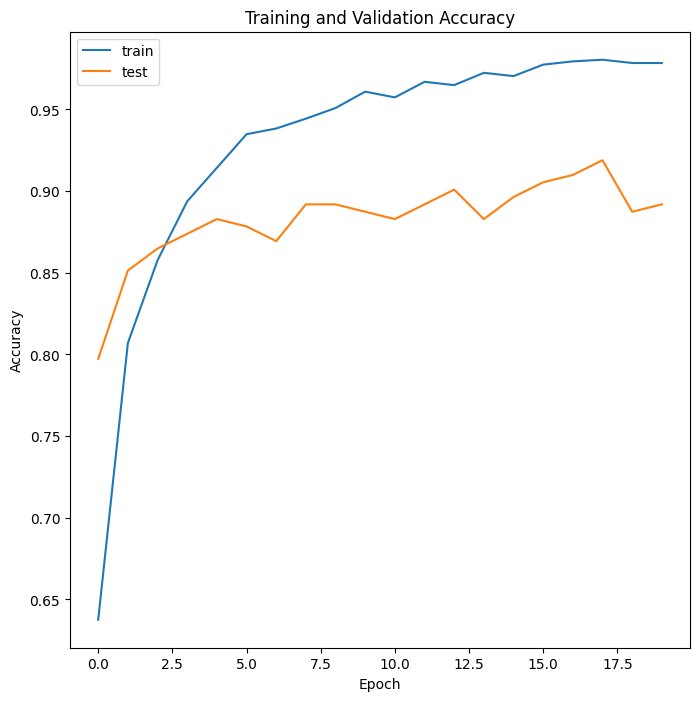

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the actual number of epochs the model trained for
epochs_range = range(len(acc))  # Use the length of 'acc' instead of a fixed range

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('train_val_acc_lstm.pdf')
plt.show()

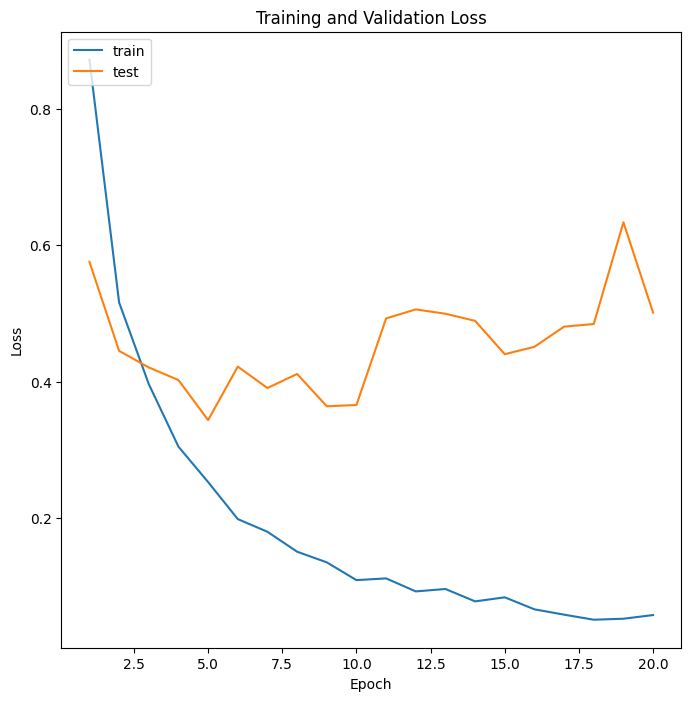

In [ ]:
def plot_metrics(history, metric):
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']
    epochs = range(1, len(train_metric)+1)

    plt.figure(figsize=(8,8))
    plt.plot(epochs,train_metric,label = f'Training {metric}')
    plt.plot(epochs,val_metric,label = f'Validation {metric}')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(['train', 'test'],loc='upper left')
    plt.savefig('train_val_loss_lstm.pdf')
    plt.show()
#Training and validation loss plot
plot_metrics(history, metric='loss')

In [ ]:
#prediction
y_pred = classifier.predict(X_test)
y_pred_class = y_pred.argmax(axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step


In [ ]:
labels=['DC','IO','RE','TD']

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_class,target_names=labels)
print(report)

              precision    recall  f1-score   support

          DC       0.83      0.50      0.62        10
          IO       0.87      1.00      0.93        59
          RE       0.94      0.96      0.95       122
          TD       1.00      0.77      0.87        31

    accuracy                           0.92       222
   macro avg       0.91      0.81      0.84       222
weighted avg       0.93      0.92      0.92       222



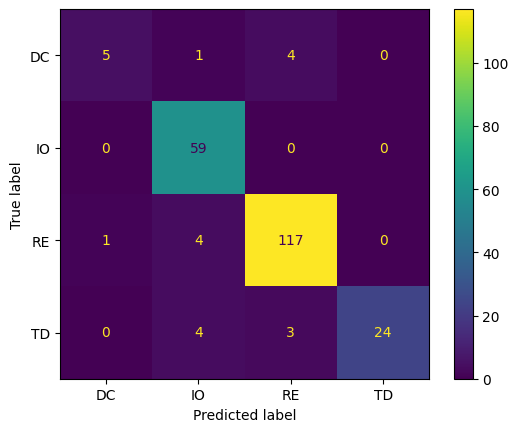

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_test,y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()
plt.savefig('confmat_lstm.pdf')
plt.show()

In [ ]:
unlabeled_data = pd.read_csv('/content/SC_unlabeled.csv')
X_unlabeled = unlabeled_data['code']
X_unlabeled

X_cleaned_unlabeled = X_unlabeled.apply(clean_solidity_code)
X_cleaned_unlabeled_sentences = [' '.join(doc) for doc in X_cleaned_unlabeled]
X_unlabeled_sequences = vectorizer(X_cleaned_unlabeled_sentences)
X_unlabeled_padded = pad_sequences(X_unlabeled_sequences, maxlen=128, padding='post', truncating='post')


In [ ]:
# Input layer
input_layer = Input(shape=(128,))  # Specify max_len as the maximum sequence length

# Embedding layer
embedding_layer = Embedding(emb_len, 128)(input_layer)

# Bidirectional LSTM layer replaced with Attention layer
lstm_layer = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.3))(embedding_layer)
attention = Attention()([lstm_layer, lstm_layer])  # Attention layer

# 1D Convolutional layer
conv1d_layer = Conv1D(64, kernel_size=3, activation='relu')(attention)

# GlobalMaxPooling1D layer
global_max_pooling_layer = GlobalMaxPooling1D()(conv1d_layer)

# Dense layers
dense_layer_1 = Dense(128, activation='relu')(global_max_pooling_layer)

output_layer = Dense(4, activation='softmax')(dense_layer_1)

# Model creation
model = Model(inputs=input_layer, outputs=output_layer)

model.load_weights('/content/saved_model/final_model_lstm.keras')

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
[2 2 2 ... 3 3 3]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        97
           1       0.97      0.99      0.98       590
           2       0.99      0.99      0.99      1218
           3       0.99      0.96      0.97       312

    accuracy                           0.99      2217
   macro avg       0.98      0.97      0.98      2217
weighted avg       0.99      0.99      0.99      2217



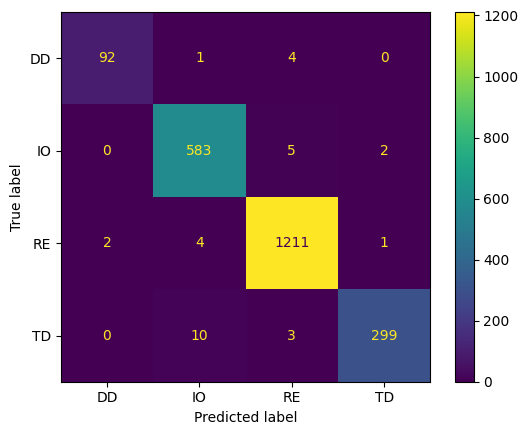

In [ ]:
y_pred_unlabeled = classifier.predict(X_cleaned_unlabeled_sentences)

# Get the predicted class for each input
predicted_classes = y_pred_unlabeled.argmax(axis=1)
print(predicted_classes)

#unlabeled_data['predicted_class'] = predicted_classes
#unlabeled_data.to_csv('predicted_unlabeled_data.csv', index=False)

y_actual = data['label_encoded']  # Replace 'label_encoded' with the actual label column name
#y_actual

# Evaluate the predictions
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Print the classification report
print("Classification Report:")
print(classification_report(y_actual, predicted_classes))

# Display the confusion matrix
cm = confusion_matrix(y_actual, predicted_classes)
labels = ['DD', 'IO', 'RE', 'TD']  # Replace with your class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='viridis')
plt.savefig('confmat_lstm_unlabeled.pdf')
plt.show()